In [1]:
import numpy as np
import pandas as pd
import uproot3 as uproot
import matplotlib.pyplot as plt 

import sqlite3

def loadFiles( tfile, treename, selbranches = ["event", "ch", "amp", "area", "time"], flatenndf=True ):
    ttree = uproot.open(tfile)
    data = ttree[treename].arrays(branches=selbranches, outputtype=pd.DataFrame, flatten=flatenndf)
    
    return data


def countevents( x, thr ):
    
    a = np.array(x)
    counts = len( a[a>thr] )
    
    return counts


def getDFRates( FILENAME ):

    ophit = loadFiles( FILENAME, "simpleLightAna/ophit_ttree", selbranches = ["event", "channel_id", "amplitude", "integral", "start_time"] )

    data = ophit.groupby(["channel_id", "event"]).amplitude.agg(list)
    data = data.reset_index()

    data['counts16'] = data['amplitude'].apply( lambda x : countevents(x, 16) )

    ttree = uproot.open(FILENAME)
    nticks = ttree["simpleLightAna/daqPMTwfttree"]["nticks"].array(entrystop=1)[0]
    
    run = ttree["simpleLightAna/eventstree"]["run"].array(entrystop=1)[0]
    timestamp = ttree["simpleLightAna/eventstree"]["timestamp"].array(entrystop=1)[0]
    events = len(np.unique( data['event'].values ))
    
    print(nticks, events)
    
    data['rate16'] = data['counts16']/( nticks*2.0*1e-9 )
    
    return data

In [30]:
df=getDFRates("../histograms/pulseDistributionHist_run6736.root")
df1=getDFRates("../histograms/pulseDistributionHist_run5573.root")

15000 2677
12500 9027


Text(0.5, 0, 'Channel ID')

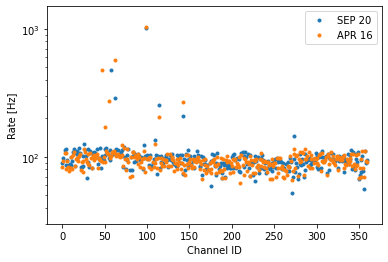

In [36]:
plt.plot(  df.groupby( 'channel_id' ).rate16.mean()/1000, '.', label='SEPTEMBER 20th' )
plt.plot(  df1.groupby( 'channel_id' ).rate16.mean()/1000, '.', label='APRIL 16th' )

plt.ylim((30, 1500))
plt.yscale("Log")
plt.legend()
plt.ylabel("Rate [kHz]")
plt.xlabel("Channel ID")


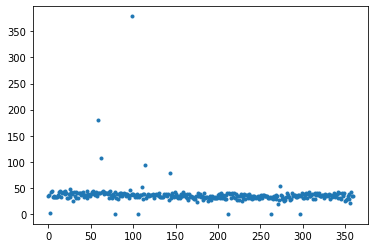

7858
350 [1.03258913] [[0.03610542]]
359 [1.49082705] [[0.1104493]]


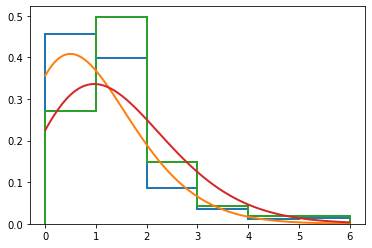

In [37]:
from scipy.optimize import curve_fit
from scipy.special import factorial

def posson_fit(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return (lamb**k/factorial(k)) * np.exp(-lamb)

nevents = len( np.unique( ophit.event.values ) )
print( nevents )

for ch in [350, 359]:
    
    xrange=(0, 6)
    nbins=xrange[1]-xrange[0]
    
    weights, edges, _ = plt.hist( data[data.channel_id==ch].counts16, range=(xrange[0],xrange[1]) ,bins=nbins, density=True, histtype='step', lw=2.0)
    centers = [ ( edges[i]+edges[i-1] ) / 2.0 for i in range( 1, len(edges) )  ]
    
    parameters, cov_matrix = curve_fit(posson_fit, centers, weights, p0=[0.0002])
    print(ch, parameters, cov_matrix)
    
    plt.plot( np.linspace(xrange[0],xrange[1],100), [ posson_fit( center, parameters[0] ) for center in np.linspace(xrange[0],xrange[1],100) ], '-', lw=2.0 )
    
    
    #plt.step( centers, weights, where='mid' )
     
    #plt.yscale("Log")

In [87]:
print( len(data[data.channel_id==4].event), len(np.unique(data[data.channel_id==4].event)) )

8209 8209


In [93]:
print(data[(data.channel_id==0) & (data.event==11)].amplitude.values)
print(data[(data.channel_id==0) & (data.event==11)].counts20.values)

[list([41.12181854248047, 34.29246139526367, 41.55277633666992, 49.041229248046875, 10.375, 47.36982727050781, 15.30948257446289])]
[5]


3123


/tmp/ipykernel_6199/1840986134.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


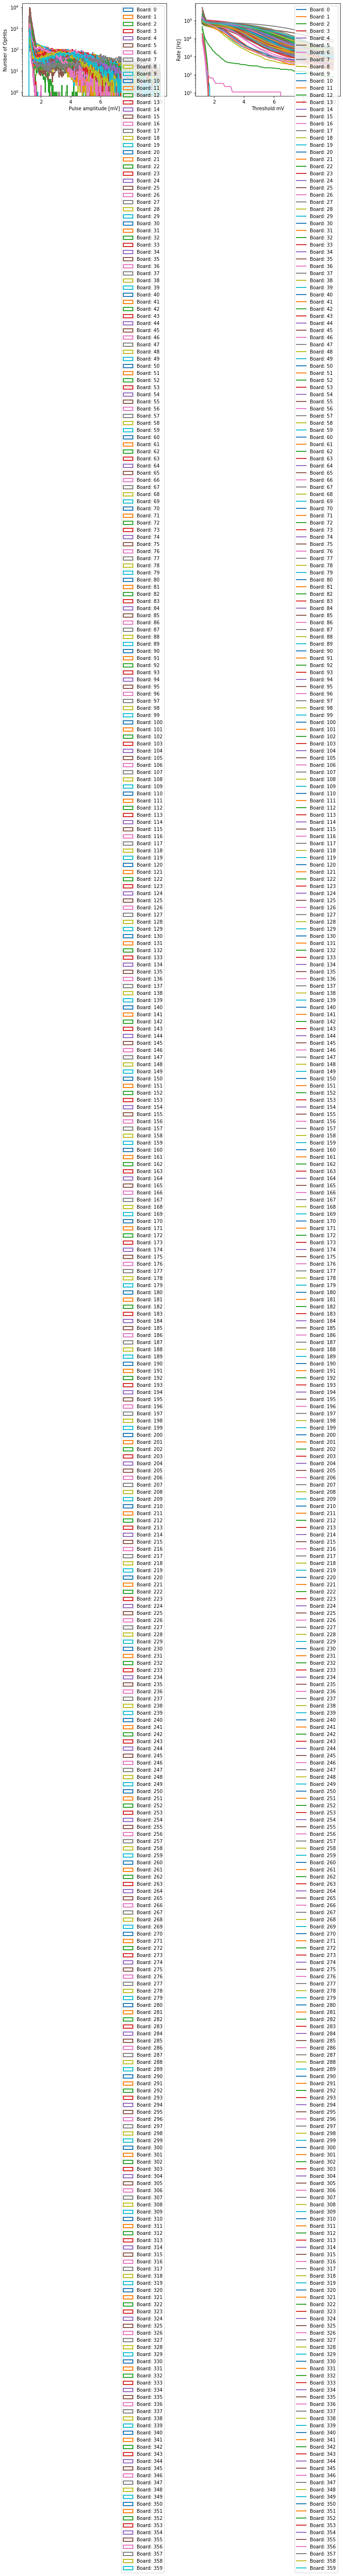

In [15]:
def getRate( data, nevents, thr=(1, 200 ), res=1, readout=30e-9 ):
    
    npoints = int( (thr[1]-thr[0]) / res )
    thrs = np.linspace( thr[0], thr[1], npoints )
    
    rates = [ len( data[data>th] ) / ( nevents*readout ) for th in thrs ]
    
    return thrs, rates

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

nevents = len( np.unique( ophit.event.values ) )
print( nevents )


fig, ax = plt.subplots(1,2, figsize=(12, 3.6))
    
for FRAGMENT in range(360):

    seldata = ophit[ophit.channel_id==FRAGMENT]
    
    ax[0].hist( seldata.amplitude*0.122, bins=300, range=(1.2,10), histtype='step', lw=2.0, density=False, label="Board: %d" % FRAGMENT )
    ax[0].set_yscale("Log")
    ax[0].set_xlabel("Pulse amplitude [mV]")
    ax[0].set_ylabel("Number of OpHits")
    ax[0].legend()
    
    thrs, rates = getRate( seldata.amplitude*0.122, nevents, thr=(1.2, 10 ), res=0.1 )
    ax[1].plot(thrs, rates, lw=2, label="Board: %d" % FRAGMENT )
    ax[1].set_yscale("Log")
    ax[1].set_xlabel("Threshold mV")
    ax[1].set_ylabel("Rate [Hz]")
    ax[1].legend()
    
    
fig.tight_layout()
#plt.savefig( "rates_adders_%s_max10.png" % wall )
    
plt.show()
